In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.utils import resample

RSEED = 42

In [2]:
data = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])
print("Shape:", data.shape)
print(data.head())

Shape: (5572, 2)
  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...



Label distribution:
 Label
ham     4825
spam     747
Name: count, dtype: int64


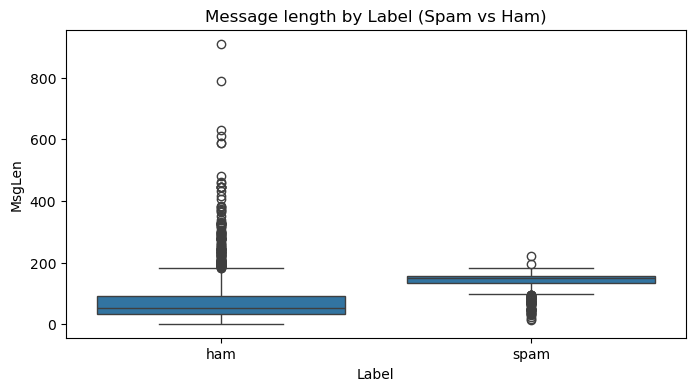

In [3]:
print("\nLabel distribution:\n", data['Label'].value_counts())
data['MsgLen'] = data['Message'].apply(len)
plt.figure(figsize=(8,4))
sns.boxplot(x='Label', y='MsgLen', data=data)
plt.title("Message length by Label (Spam vs Ham)")
plt.show()


In [4]:
def clean_text(text):
    """
    Basic cleaning:
    - lowercase
    - remove URLs, emails, numbers optionally
    - remove punctuation
    - keep whitespace separated tokens
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # remove URLs
    text = re.sub(r'\S+@\S+', '', text)                   # remove emails
    text = re.sub(r'\d+', '', text)                       # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
data['Cleaned'] = data['Message'].apply(clean_text)
data.head()

,Label,Message,MsgLen,Cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...


In [6]:
le = LabelEncoder()
data['LabelNum'] = le.fit_transform(data['Label'])  # 'ham'->0, 'spam'->1
print("\nEncoded labels:", dict(zip(le.classes_, le.transform(le.classes_))))



Encoded labels: {'ham': np.int64(0), 'spam': np.int64(1)}


In [7]:
X = data['Cleaned']
y = data['LabelNum']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RSEED, stratify=y
)
print("\nTrain/Test sizes:", X_train.shape, X_test.shape)
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))



Train/Test sizes: (4457,) (1115,)
Train label distribution:
 LabelNum
0    0.865829
1    0.134171
Name: proportion, dtype: float64
Test label distribution:
 LabelNum
0    0.866368
1    0.133632
Name: proportion, dtype: float64


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=2000)
cv_fit = cv.fit_transform(X_train)
sum_words = cv_fit.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print("\nTop 10 words overall:", words_freq[:10])


Top 10 words overall: [('im', np.int64(375)), ('ur', np.int64(296)), ('just', np.int64(280)), ('ltgt', np.int64(225)), ('free', np.int64(224)), ('dont', np.int64(220)), ('ok', np.int64(211)), ('got', np.int64(207)), ('know', np.int64(206)), ('ill', np.int64(194))]


In [9]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
    ('clf', MultinomialNB())
])

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
    ('clf', LogisticRegression(max_iter=1000, random_state=RSEED))
])


In [10]:
nb_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

# =========================

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])


=== Naive Bayes (MultinomialNB) ===
Accuracy: 0.9641255605381166
Precision: 1.0
Recall: 0.7315436241610739
F1-score: 0.8449612403100775
ROC-AUC: 0.9807898064390623

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115



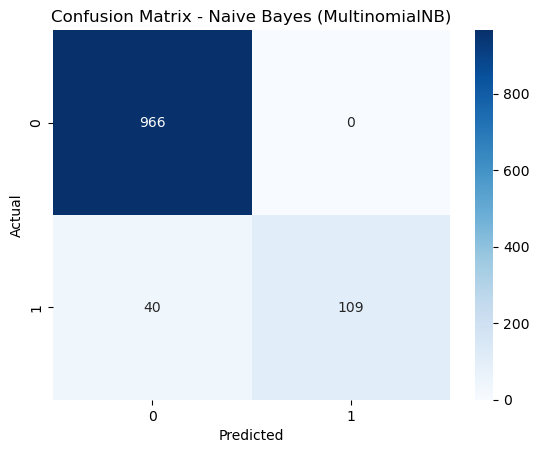

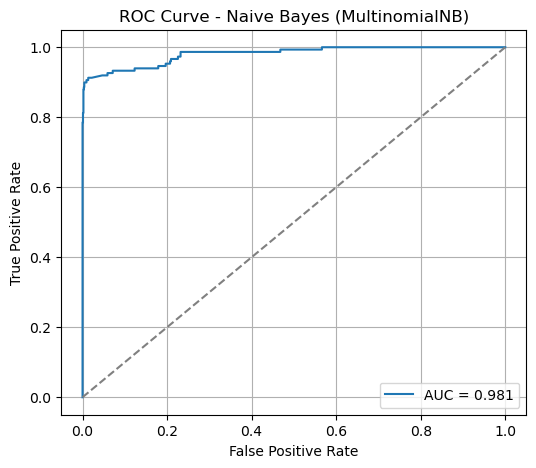


=== Logistic Regression ===
Accuracy: 0.967713004484305
Precision: 1.0
Recall: 0.7583892617449665
F1-score: 0.8625954198473282
ROC-AUC: 0.9837356010393653

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



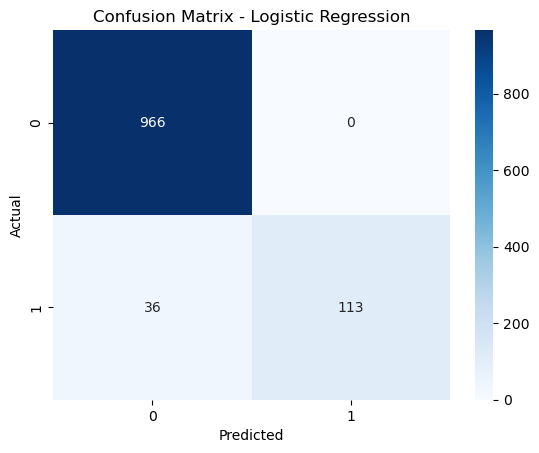

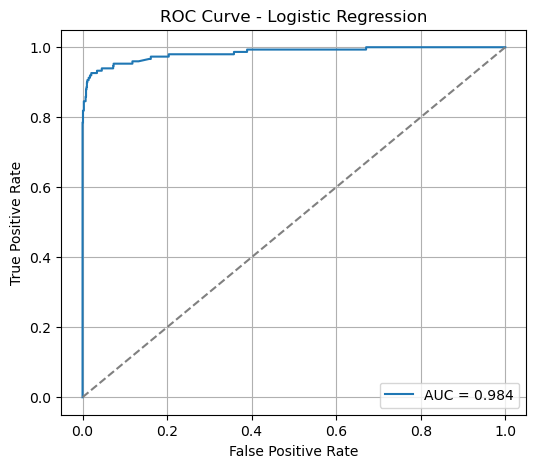

In [11]:
def evaluate_model(pipeline, X_test, y_test, model_name="Model"):
    y_pred = pipeline.predict(X_test)
    y_proba = None
    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:,1]
    elif hasattr(pipeline.named_steps['clf'], "predict_proba"):
        y_proba = pipeline.named_steps['clf'].predict_proba(pipeline.named_steps['tfidf'].transform(X_test))[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"\n=== {model_name} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    if roc is not None:
        print("ROC-AUC:", roc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    if y_proba is not None:
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Evaluate NB
evaluate_model(nb_pipeline, X_test, y_test, model_name="Naive Bayes (MultinomialNB)")

# Evaluate LR
evaluate_model(lr_pipeline, X_test, y_test, model_name="Logistic Regression")